Sources: 
1. https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3
2. https://www.youtube.com/channel/UCZPFjMe1uRSirmSpznqvJfQ

In [1]:
import tensorflow as tf
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pydot
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
data_path = "data.json"

In [3]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data =json.load(fp)
        
    # want to convert lists into numpy arrays
    X = np.asarray(data["mfcc"])
    y = np.asarray(data["labels"])
    
    return X, y

In [4]:
def prepare_datasets(test_size, validation_size):
    # loading the data
    X, y = load_data(data_path)
    
    # creating a training and testing split in the data first
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # now creating the training and validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                    test_size=validation_size)
    # for CNN tf expects a 3-d array for each sample. The third dimension for us is one.
    X_train = X_train[..., np.newaxis] #this will now be a 4D array, not sure if we need this
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test 

In [5]:
def build_model(input_shape):
    #create the model
    model = keras.Sequential()
    
    # first conv layer, 32 filters (kernals), grid size, and the activation function
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # second conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # third conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    #flatten the output and then this goes into a dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    #this helps guard against overfitting
    model.add(keras.layers.Dropout(0.3))
    # output, want as many layers as the numbers of classifications we are trying to predict
    model.add(keras.layers.Dense(14, activation='softmax'))
    
    return model

In [12]:
if __name__ == "__main__":
    # creating all of our data we need
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.3, 0.2)
    
    # building the model here 
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3] )
    # builds the network from the function constrcuted above
    model = build_model(input_shape)
    
    #compiling the network
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    #training the network
    history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation),
             batch_size=30, epochs=100)
    
    # evaluating the netowrk on the next set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on the test set is: {}".format(test_accuracy))
    

Train on 1568 samples, validate on 392 samples
Epoch 1/100
1568/1568 [==============================] - 3s 2ms/sample - loss: 3.2056 - accuracy: 0.0874 - val_loss: 3.4270 - val_accuracy: 0.0791
Epoch 2/100
1568/1568 [==============================] - 1s 704us/sample - loss: 2.7367 - accuracy: 0.1378 - val_loss: 2.6831 - val_accuracy: 0.0995
Epoch 3/100
1568/1568 [==============================] - 1s 626us/sample - loss: 2.4100 - accuracy: 0.2239 - val_loss: 2.3512 - val_accuracy: 0.1862
Epoch 4/100
1568/1568 [==============================] - 1s 619us/sample - loss: 2.1968 - accuracy: 0.2742 - val_loss: 2.1306 - val_accuracy: 0.2857
Epoch 5/100
1568/1568 [==============================] - 1s 630us/sample - loss: 1.9936 - accuracy: 0.3527 - val_loss: 1.9542 - val_accuracy: 0.3673
Epoch 6/100
1568/1568 [==============================] - 1s 631us/sample - loss: 1.8343 - accuracy: 0.4043 - val_loss: 1.8071 - val_accuracy: 0.4413
Epoch 7/100
1568/1568 [==============================] - 1s 6

In [68]:
def predict(model, x, y):
    x = x[np.newaxis, ...]
    
    # the prediction is 2d
    preds = model.predict(x) # expects a 4d array but X is originally 3d
    
    # want to extract the index of X with the max favlue
    pred_index = np.argmax(preds, axis = 1 ) # 
    print("Expected index of the output: {}, Predicted index: {}".format(y, pred_index))

In [91]:
# making predictions now
x1 = X_test[122]
y1 = y_test[122]

predict(model, x1, y1)

Expected index of the output: 7, Predicted index: [7]


In [71]:
# another test
x2 = X_test[132]
y2 = y_test[132]

predict(model, x2, y2)

Expected index of the output: 2, Predicted index: [2]


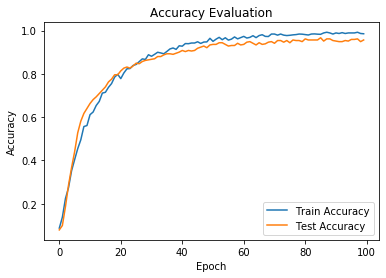

In [129]:
fig, axs = plt.subplots()

# create accuracy subplots
axs.plot(history.history["accuracy"], label="Train Accuracy")
axs.plot(history.history["val_accuracy"], label="Test Accuracy")
axs.set_ylabel("Accuracy")
axs.set_xlabel("Epoch")
axs.legend(loc="lower right")
axs.set_title("Accuracy Evaluation")
plt.savefig("cnn_initial_accuracy")
plt.show()


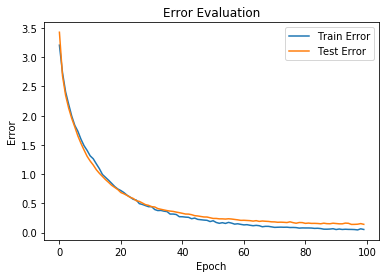

In [126]:
fig, axs = plt.subplots()    
axs.plot(history.history["loss"], label="Train Error")
axs.plot(history.history["val_loss"], label="Test Error")
axs.set_ylabel("Error") 
axs.set_xlabel("Epoch")
axs.legend(loc="upper right")
axs.set_title("Error Evaluation")
plt.savefig("cnn_initial_error")
plt.show()

In [116]:
# testing the model with noisy data 
# first import the new data 
data_path2 = "data-light-noise.json"
X1, Y1 = load_data(data_path2)
X1 = X1[...,np.newaxis]

In [99]:
x = X1[122]
y = Y1[122]
a = X1[135]
b = Y1[135]

In [100]:
predict(model, x, y)
predict(model, a, b)

Expected index of the output: 0, Predicted index: [2]
Expected index of the output: 0, Predicted index: [0]


In [117]:
test_error_noise, test_accuracy_noise= model.evaluate(X1, Y1, verbose=1)
print("Accuracy on the Light Noise set is: {}".format(test_accuracy_noise))

2800/2800 [==============================] - 1s 283us/sample - loss: 1.7499 - accuracy: 0.5754
Accuracy on the Light Noise set is: 0.5753571391105652


In [130]:
data_path3 = "data-heavy-noise.json"
X2, Y2 = load_data(data_path3)
X2 = X2[...,np.newaxis]

In [131]:
test_error_heavy, test_accuracy_heavy= model.evaluate(X2, Y2, verbose=1)
print("Accuracy on the Heavy Noise set is: {}".format(test_accuracy_heavy))

2800/2800 [==============================] - 1s 269us/sample - loss: 8.6165 - accuracy: 0.0911
Accuracy on the Heavy Noise set is: 0.09107142686843872


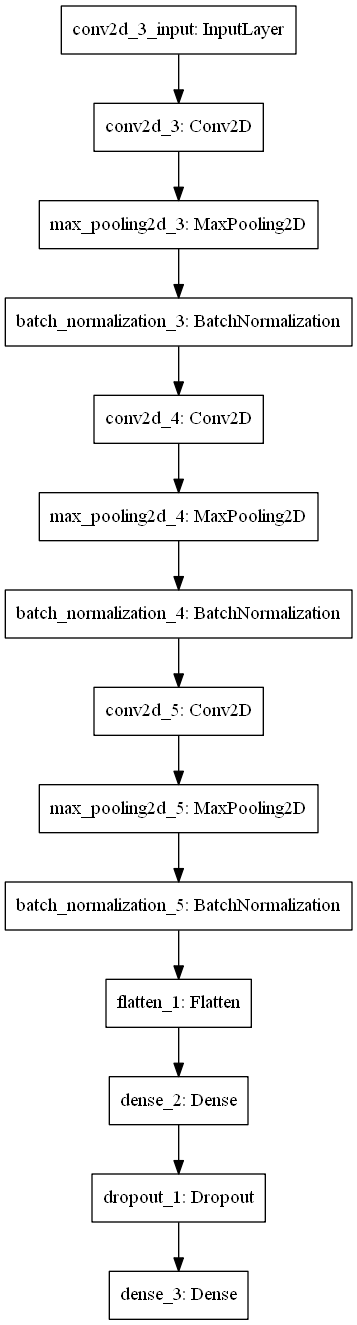

In [132]:
from tensorflow.keras import layers
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=False)

In [133]:
def prepare_datasets_(data_path, test_size, validation_size):
    # loading the data
    X, y = load_data(data_path)
    
    # creating a training and testing split in the data first
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # now creating the training and validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                    test_size=validation_size)
    # for CNN tf expects a 3-d array for each sample. The third dimension for us is one.
    X_train = X_train[..., np.newaxis] #this will now be a 4D array, not sure if we need this
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [ ]:
X_train2, X_validation2, X_test2, y_train2, y_validation2, y_test2 = \
prepare_datasets_("data-light-noise.json", 0.2, 0.3)

In [ ]:
history2 = model.fit(X_train2, y_train2, validation_data=(X_validation2,y_validation2),
                     batch_size=30, epochs=50)